In [1]:
# Setup code

import sys
sys.path.insert(0, "..")
basedir = "../.."

import datetime
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pickle
import time
from sklearn.decomposition import PCA

import models
import utils

%matplotlib widget

plt.rcParams["figure.figsize"] = (7, 3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class TrajectoryAE():
  def network(self, batch):
    B, T, M = batch.shape
    #times = torch.tensor(np.repeat(np.arange(1, T + 1), B)).to(self.device).float().reshape(-1, 1)
    data = torch.tensor(batch.cpu().numpy().reshape((B*T, M), order="F"))
    encoded = self.ae.encode(data)
    #augmented = torch.cat((encoded, times), dim=1)

    return data, encoded, self.ae.decode(encoded)
    #return data, augmented, self.ae.decode(augmented)

  def __init__(self, ae : models.FFAutoencoder, dataset : utils.DynamicData, tensorboard_directory=None, suffix=None, seed=0, device=0, straightness=0.01):
    self.ae = ae
    self.device = device
    self.straightness = straightness
    self.dataset = dataset

    self.writer = None
    if tensorboard_directory is not None:
      name = f"./runs/{datetime.datetime.now().strftime('%d-%B-%Y')}/{tensorboard_directory}/{suffix if suffix is not None else datetime.datetime.now().strftime('%H.%M.%S')}/tae/"
      self.writer = torch.utils.tensorboard.SummaryWriter(name)
      print("Tensorboard writer location is " + name)

    torch.manual_seed(seed)
    np.random.seed(seed)

  def approximation_comparison(self, k=2):
    pca = PCA(n_components=k)
    projected_pca = pca.inverse_transform(pca.fit_transform(self.dataset))
    N, M = projected_pca.shape

    projected_ae = self.ae.forward(torch.tensor(self.dataset).to(self.device).float()).cpu().detach().numpy()

    fig, ax = plt.subplots()

    @widgets.interact(i=(0, N-1))
    def plot(i=0):
      ax.clear()
      ax.plot(self.data[i, :], label="Real Data")
      ax.plot(projected_pca[i, :], label="PCA Approximation")
      ax.plot(projected_ae[i, :], label="AE Approximation")
      ax.legend()
      
  def get_projerr(self, testarr, ord=2):
    orig, enc, proj = self.network(testarr)
    # domain = torch.tensor(testarr).to(self.device).float()
    # projected = self.ae(domain).cpu().detach().numpy()
    # domain = domain.cpu().detach().numpy()

    orig = orig.cpu().detach().numpy()
    proj = proj.cpu().detach().numpy()
    return np.mean(np.linalg.norm(orig - proj, axis=1, ord=ord) / np.linalg.norm(orig, axis=1, ord=ord))

  def plot_encoding(self, p, step=None, tensorboard=False, maxscatter=10000):
    if type(p) == type(0):
      p = [p]

    dim = self.ae.reduced

    arr = torch.tensor(self.dataset.data).to(self.device).float()
    orig, enc, proj = self.network(arr)
    arr = arr.cpu()#.detach().numpy()
    orig = orig.cpu()#.detach().numpy()
    proj = proj.cpu()#.detach().numpy()

    points = enc.cpu().detach().numpy()
    
    N, T, M = self.dataset.data.shape
    times =  np.repeat(np.arange(1, T + 1), N)# np.tile(np.arange(1, T+1), N).reshape(-1, 1)
    params = np.tile(self.dataset.params, (T, 1))#  utils.duplicate_rows(self.dataset.params, T)

    plt.rcParams.update({'font.size': 16})

    for pp in p:
      fig = plt.figure(figsize=(14, 6))

      if dim == 2:
        axes = [fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)]
        #fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        sc0 = axes[0].scatter(points[:maxscatter, 0], points[:maxscatter, 1], c=params[:maxscatter, pp], s=2)
        plt.colorbar(sc0, ax=axes[0], location="right", pad=0)
        axes[0].set_xlabel("$z_1$")
        axes[0].set_ylabel("$z_2$")
        axes[0].set_title(f"Parameter {pp}")

        sc1 = axes[1].scatter(points[:maxscatter, 0], points[:maxscatter, 1], c=times[:maxscatter], s=2, cmap="copper")
        plt.colorbar(sc1, ax=axes[1], location="right", pad=0)
        axes[1].set_xlabel("$z_1$")
        axes[1].set_ylabel("$z_2$")
        axes[1].set_title(f"Time")
      elif dim >= 3:
        axes = [fig.add_subplot(1, 2, 1, projection="3d"), fig.add_subplot(1, 2, 2, projection="3d")]
        #fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        sc0 = axes[0].scatter(points[:maxscatter, 0], points[:maxscatter, 1], points[:maxscatter, 2], c=params[:maxscatter, pp], s=2)
        plt.colorbar(sc0, ax=axes[0], location="right", pad=0)
        axes[0].set_xlabel("$z_1$")
        axes[0].set_ylabel("$z_2$")
        axes[0].set_zlabel("$z_3$")
        axes[0].set_title(f"Parameter {pp}")

        sc1 = axes[1].scatter(points[:maxscatter, 0], points[:maxscatter, 1], points[:maxscatter, 2], c=times[:maxscatter], s=2, cmap="copper")
        plt.colorbar(sc1, ax=axes[1], location="right", pad=0)
        axes[1].set_xlabel("$z_1$")
        axes[1].set_ylabel("$z_2$")
        axes[1].set_zlabel("$z_3$")
        axes[1].set_title(f"Time")
      else:
        assert(False)

      fig.tight_layout()

      if tensorboard:
        assert(step is not None)
        fig.suptitle(step)
        self.writer.add_figure(f'encode/latent-p{pp}', fig, global_step=step)
        self.writer.flush()
        torch.cuda.empty_cache()
        plt.close(fig)
      else:
        plt.show(fig)

      return fig

  def ae_epoch(self, dataloader, optimizer=None, ep=0, printinterval=10, snapshots=None, loss=None, testarr=None, encoding_param=None, plotmode=0):
    losses = []
    testerrors1 = []
    testerrors2 = []
    testerrorsinf = []

    model = self.ae
    device = self.device
    
    def closure(batch):
        optimizer.zero_grad()

        orig, enc, proj = self.network(batch)

        res = loss(orig, proj)
        lossval = res

        T = enc.shape[0]
        i_values = torch.arange(1, T)
        weights = (T - i_values) / T

        if self.straightness > 0:
          term1 = torch.outer(weights, enc[0, :])
          term2 = torch.outer((i_values / T), enc[-1, :])
          term3 = enc[i_values, :]
          penalty = loss(term1 + term2, term3)

          lossval = res + self.straightness * penalty
        else:
          lossval = res
          penalty = 0

        if self.writer is not None:
          if self.aestep % 10 == 0:
            self.writer.add_scalar("encode/loss", lossval, global_step=self.aestep)
            self.writer.add_scalar("encode/loss_reconstruct", error, global_step=self.aestep)
            self.writer.add_scalar("encode/loss_penalty", self.straightness * penalty, global_step=self.aestep)

        lossval.backward()
        return res

    for batch in dataloader:
        B, T, M = batch.shape

        for b in range(B):
          self.aestep += 1
          data = batch[b:b+1, :, :].to(device).float()
          error = optimizer.step(lambda: closure(data))
          losses.append(error)

        if plotmode == 2:
          self.plot_encoding(encoding_param, step=self.aestep, tensorboard=True)

    # print test
    if printinterval > 0 and (ep % printinterval == 0):
        testarr = torch.tensor(testarr).float().to(device)
        testerr1 = self.get_projerr(testarr, ord=1)
        testerr2 = self.get_projerr(testarr, ord=2)
        testerrinf = self.get_projerr(testarr, ord=np.inf)

        testerrors1.append(testerr1)
        testerrors2.append(testerr2)
        testerrorsinf.append(testerrinf)
        
        print(f"{ep+1}: Train Loss {error:.3e}, Relative Projection Error (1, 2, inf): {testerr1:3f}, {testerr2:3f}, {testerrinf:3f}")
        #snapshots.append({k: v.cpu() for k, v in model.state_dict().items()})

        if self.writer is not None:
            self.writer.add_scalar("encode/relativeL1", testerr1, global_step=ep)
            self.writer.add_scalar("encode/relativeL2", testerr2, global_step=ep)
            self.writer.add_scalar("encode/relativeLInf", testerrinf, global_step=ep)

    return losses, testerrors1, testerrors2, testerrorsinf

  def train_ae(self, epochs, optim=torch.optim.AdamW, lr=1e-4, printinterval=10, batch=32, ridge=0, loss=None, encoding_param=-1, plotmode=0, lbfgs=False):
    if loss is None:
       loss = nn.MSELoss()
    else:
       loss = loss()

    if encoding_param == -1:
      encoding_param = []
      P = self.dataset.params.shape[1]

      for p in range(P):
        if np.abs(self.dataset.params[0, p] - self.dataset.params[1, p]) > 0:
          encoding_param.append(p)

    snapshots = []
    losses, testerrors1, testerrors2, testerrorsinf = [], [], [], []
    
    opt = optim(self.ae.parameters(), lr=lr, weight_decay=ridge)
    
    datacopy = self.dataset.data
    #np.random.shuffle(datacopy)
    numtrain = int(datacopy.shape[0] * 0.8)
    train = datacopy[:numtrain, :, :]
    test = datacopy[numtrain:, :, :]

    print(utils.num_params(self.ae))
    print(f"Starting training AE at {time.asctime()}...")
    print("train", train.shape, "test", test.shape)

    dataloader = torch.utils.data.DataLoader(train, shuffle=False, batch_size=batch)

    self.aestep = 0
    for ep in range(epochs):
        lossesN, testerrors1N, testerrors2N, testerrorsinfN = self.ae_epoch(dataloader, optimizer=opt, ep=ep, printinterval=printinterval, snapshots=snapshots, loss=loss, testarr=test, encoding_param=encoding_param, plotmode=plotmode)
        losses += lossesN; testerrors1 += testerrors1N; testerrors2 += testerrors2N; testerrorsinf += testerrorsinfN
        
        if plotmode == 1:
          self.plot_encoding(encoding_param, step=self.aestep, tensorboard=True)

    if lbfgs:
      print("Now for LBFGS")
      lbfgs_opt = torch.optim.LBFGS(self.ae.parameters(), line_search_fn="strong_wolfe", lr=1e-1)
      for ep in range(int(epochs/20)):
        lossesN, testerrors1N, testerrors2N, testerrorsinfN = self.ae_epoch(dataloader, optimizer=lbfgs_opt, ep=ep+epochs, printinterval=1, snapshots=snapshots, loss=loss, testarr=test, encoding_param=encoding_param, plotmode=plotmode)
        losses += lossesN; testerrors1 += testerrors1N; testerrors2 += testerrors2N; testerrorsinf += testerrorsinfN
        
        if plotmode == 1:
          self.plot_encoding(encoding_param, step=self.aestep, tensorboard=True)
    

    print(f"Finish training domain at {time.asctime()}.")
    return { "losses": losses, "testerrors1": testerrors1, "testerrors2": testerrors2, "testerrorsinf": testerrorsinf, "snapshots": snapshots }

  def plot_scatter(self, p, points, params, times):
    plt.rcParams.update({'font.size': 16})

    dim = points.shape[1]

    for pp in p:
      fig = plt.figure(figsize=(14, 6))

      if dim == 2:
        axes = [fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)]
        #fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        sc0 = axes[0].scatter(points[:, 0], points[:, 1], c=params[:, pp], s=2)
        plt.colorbar(sc0, ax=axes[0], location="right", pad=0)
        axes[0].set_xlabel("$z_1$")
        axes[0].set_ylabel("$z_2$")
        axes[0].set_title(f"Parameter {pp}")

        sc1 = axes[1].scatter(points[:, 0], points[:, 1], c=times, s=2, cmap="copper")
        plt.colorbar(sc1, ax=axes[1], location="right", pad=0)
        axes[1].set_xlabel("$z_1$")
        axes[1].set_ylabel("$z_2$")
        axes[1].set_title(f"Time")
      elif dim >= 3:
        axes = [fig.add_subplot(1, 2, 1, projection="3d"), fig.add_subplot(1, 2, 2, projection="3d")]
        #fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        sc0 = axes[0].scatter(points[:, 0], points[:, 1], points[:, 2], c=params[:, pp], s=2)
        plt.colorbar(sc0, ax=axes[0], location="right", pad=0)
        axes[0].set_xlabel("$z_1$")
        axes[0].set_ylabel("$z_2$")
        axes[0].set_zlabel("$z_3$")
        axes[0].set_title(f"Parameter {pp}")

        sc1 = axes[1].scatter(points[:, 0], points[:, 1], points[:, 2], c=times, s=2, cmap="copper")
        plt.colorbar(sc1, ax=axes[1], location="right", pad=0)
        axes[1].set_xlabel("$z_1$")
        axes[1].set_ylabel("$z_2$")
        axes[1].set_zlabel("$z_3$")
        axes[1].set_title(f"Time")
      else:
        assert(False)

      fig.tight_layout()

    return fig

  def plot_trajectories(self, num=0, p=0):
    if type(num) == type(0):
      num = [num]

    if type(p) == type(0):
      p = [p]

    data = self.dataset.data[num, :, :]
    arr = torch.tensor(data).to(self.device).float()
    orig, enc, proj = self.network(arr)
    arr = arr.cpu()
    orig = orig.cpu()
    proj = proj.cpu()

    points = enc.cpu().detach().numpy()
    
    N, T, M = data.shape
    times = np.repeat(np.arange(0, T), N)
    params = np.tile(self.dataset.params[num, :], (T, 1))

    return self.plot_scatter(p, points, params, times)

  def timeslice_error(self, time):
    if type(time) == type(0):
      time = [time]

    data = self.dataset.data[:, time, :]
    arr = torch.tensor(data).to(self.device).float()
    orig, enc, proj = self.network(arr)
    arr = arr.cpu()
    orig = orig.cpu().detach().numpy()
    proj = proj.cpu().detach().numpy()

    return np.mean([np.linalg.norm(proj - orig, axis=1) / np.linalg.norm(orig, axis=1)])

  def plot_timeslice(self, time=0, p=0):
    if type(time) == type(0):
      time = [time]

    if type(p) == type(0):
      p = [p]

    data = self.dataset.data[:, time, :]
    arr = torch.tensor(data).to(self.device).float()
    orig, enc, proj = self.network(arr)
    arr = arr.cpu()
    orig = orig.cpu()
    proj = proj.cpu()

    points = enc.cpu().detach().numpy()
    
    N, T, M = data.shape
    times = np.repeat(time, N)
    params = np.tile(self.dataset.params, (T, 1))

    return self.plot_scatter(p, points, params, times)

Using backend: pytorch

c:\Users\Admin\Anaconda3\envs\nn\lib\site-packages\torch\__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:433.)
  _C._set_default_tensor_type(t)


In [30]:
from torchdiffeq import odeint

class TrajectoryVF(nn.Module):
    def __init__(self, seq, activation):
        super().__init__()

        self.layers = nn.ModuleList([nn.Linear(seq[i], seq[i+1]) for i in range(len(seq) - 1)])
        self.s = activation

        if seq[0] == seq[-1]:
            self.autonomous = True
        elif seq[0] == seq[-1] + 1:
            self.autonomous = False
        else:
            assert(False)

    def forward(self, t, x):
        if not self.autonomous:
            tvec = torch.ones((x.shape[0], 1)) * t
            x = torch.column_stack((x, tvec))

        for i, layer in enumerate(self.layers):
            x = layer(x)
            if not i == len(self.layers) - 1:
                x = self.s(x)      
                        
        return x
    
def sample_vf(vf, x, T, t0=0, t1=1, plot=True):
    t_span = torch.linspace(t0, t1, T+1)
    out = odeint(vf, x, t_span, method=vf.method).cpu().detach().numpy()

    if plot:
        fig, ax = plt.subplots()

        for i in range(out.shape[0]):
            ax.scatter(out[i, :, 0], out[i, :, 1], label=i)

        ax.legend()

        return fig
    else:
        return out

def quiver_vf(vf, n=21, xs=(0, 1), ys=(0, 1)):
    x = np.linspace(xs[0], xs[1], n)
    y = np.linspace(ys[0], ys[1], n)
    grid_x, grid_y = np.meshgrid(x, y)

    grid = np.array([grid_x.flatten(), grid_y.flatten()]).T
    vecs = vf(0, torch.tensor(grid).float()).cpu().detach().numpy()

    fig, ax = plt.subplots(figsize=(8, 6))
    sc = ax.quiver(grid[:, 0], grid[:, 1], vecs[:, 0], vecs[:, 1], np.linalg.norm(vecs, axis=1), cmap="winter", angles="xy", scale=1, units="xy")
    plt.colorbar(sc, ax=ax)
    fig.axes[1].set_title("Length")

    return fig

In [23]:
class VFTrainer():
  def __init__(self, vf, ae, dataset, tensorboard_directory=None, suffix=None, seed=0, device=0, method="rk4"):
    self.vf = vf
    self.ae = ae
    self.dataset = dataset
    self.device = device
    self.method = method

    self.writer = None
    if tensorboard_directory is not None:
      name = f"./runs/{datetime.datetime.now().strftime('%d-%B-%Y')}/{tensorboard_directory}/{suffix if suffix is not None else datetime.datetime.now().strftime('%H.%M.%S')}/tae/"
      self.writer = torch.utils.tensorboard.SummaryWriter(name)
      print("Tensorboard writer location is " + name)

    torch.manual_seed(seed)
    np.random.seed(seed)

  # keep this, along with quiver_vf which you should include as a subplot
  def plot_vf(self, arr):
    xs = (min(arr[:, 0]), max(arr[:, 0]))
    ys = (min(arr[:, 1]), max(arr[:, 1]))

    return quiver_vf(self.vf, xs=xs, ys=ys)

  def vf_epoch(self, dataloader, optimizer, ep=0, printinterval=10, loss=None, testarr=None):
    losses = []
    testerrors1 = []
    testerrors2 = []
    testerrorsinf = []

    device = self.device
    
    def closure(batch):
      B, T, K = batch.shape
      optimizer.zero_grad()

      #cumulative loss
      initial = batch[:, 0, :].to(device).float()
      tspan = torch.linspace(0, 10, T)
      trajectory = odeint(self.vf, initial, tspan, method=self.method).transpose(0, 1)

      trajectory = trajectory.reshape(B*T, K)
      batch = batch.reshape(B*T, K)

      lossval = loss(trajectory, batch)

      #tspan = [0, 1]
      #trajectory = odeint(self.vf, batch, tspan, method='')

      if self.writer is not None:
        if self.aestep % 5 == 0:
          self.writer.add_scalar("encode/loss", lossval, global_step=self.aestep)

      lossval.backward()
      return lossval

    for batch in dataloader:
      self.aestep += 1
      error = optimizer.step(lambda: closure(batch))
      losses.append(error)

    # print test
    if printinterval > 0 and (ep % printinterval == 0):
        testarr = torch.tensor(testarr).float().to(device)

        B, T, K = testarr.shape

        initial = testarr[:, 0, :].to(device).float()
        tspan = torch.linspace(0, 10, T)
        trajectory = odeint(self.vf, initial, tspan, method=self.method).transpose(0, 1)

        trajectory = trajectory.reshape(B*T, K).cpu().detach().numpy()
        testarr = testarr.reshape(B*T, K).cpu().detach().numpy()

        testerr1 = np.mean(np.linalg.norm(trajectory - testarr, axis=1, ord=1) / np.linalg.norm(testarr, axis=1, ord=1))
        testerr2 = np.mean(np.linalg.norm(trajectory - testarr, axis=1, ord=2) / np.linalg.norm(testarr, axis=1, ord=2))
        testerrinf = np.mean(np.linalg.norm(trajectory - testarr, axis=1, ord=np.inf) / np.linalg.norm(testarr, axis=1, ord=np.inf))
        
        print(f"{ep+1}: Train Loss {error:.3e}, Relative Error (1, 2, inf): {testerr1:3f}, {testerr2:3f}, {testerrinf:3f}")
        #snapshots.append({k: v.cpu() for k, v in self.ae.state_dict().items()})

        if self.writer is not None:
            self.writer.add_scalar("vf/relativeL1", testerr1, global_step=ep)
            self.writer.add_scalar("vf/relativeL2", testerr2, global_step=ep)
            self.writer.add_scalar("vf/relativeLInf", testerrinf, global_step=ep)

            if K == 2:
              fig = self.plot_vf(testarr)
              self.writer.add_figure("vf/plot", fig, global_step=ep)

    return losses, testerrors1, testerrors2, testerrorsinf

  def train_vf(self, epochs, optim=torch.optim.Adam, lr=1e-4, printinterval=10, batch=16, ridge=0, loss=None):
    if loss is None:
       loss = nn.MSELoss()
    else:
       loss = loss()

    snapshots = []
    losses, testerrors1, testerrors2, testerrorsinf = [], [], [], []

    opt = optim(self.vf.parameters(), lr=lr, weight_decay=ridge)

    datacopy = self.dataset.data.copy()
    #np.random.shuffle(datacopy)

    projected = self.ae.encode(torch.tensor(datacopy).to(self.device).float()).detach()

    numtrain = int(projected.shape[0] * 0.8)
    train = projected[:numtrain, :, :]
    test = projected[numtrain:, :, :]
    dataloader = torch.utils.data.DataLoader(train, shuffle=False, batch_size=batch)

    print(utils.num_params(self.vf))
    print(f"Starting training VF at {time.asctime()}...")
    print("train", train.shape, "test", test.shape)

    self.aestep = 0
    for ep in range(epochs):
        lossesN, testerrors1N, testerrors2N, testerrorsinfN = self.vf_epoch(dataloader, opt, ep=ep, printinterval=printinterval, loss=loss, testarr=test)
        losses += lossesN; testerrors1 += testerrors1N; testerrors2 += testerrors2N; testerrorsinf += testerrorsinfN

    print(f"Finish training domain at {time.asctime()}.")
    return { "losses": losses, "testerrors1": testerrors1, "testerrors2": testerrors2, "testerrorsinf": testerrorsinf, "snapshots": snapshots }


In [16]:
basedir = "../.."
dataset = utils.DynamicData((f"{basedir}/datasets/burgers/grfarc2visc0p001-shift.mat", "grfarc2visc0p001"))
#dataset = utils.DynamicData(("../datasets/transport/hats2_2500_shift.mat", "alldata"))
#dataset = utils.DynamicData(("../datasets/kdv/kdv2-scale.mat", "kdv2wide"))
#dataset = utils.DynamicData(("../datasets/ks/ks2.mat", "ks2"))
dataset.shuffle_inplace()

dataset.subset_data(500)
dataset.downsample(4)
dataset.scaledown()
#dataset.data = dataset.data[:, ::5, :]
print(dataset.data.shape)

(500, 51, 256)


In [33]:
L = 3
p = 200
din = dataset.data.shape[2]
k = 2

name = "burgersshift"

st = 0
ae = models.FFAutoencoder([din] + [p] * L + [k], [k] + [p] * L + [din], nn.ReLU())
#ae = models.load_ae("burgersshift-0at27-March-2024-17.35.40.pickle")
tae = TrajectoryAE(ae, dataset, f"{name}-{st}", device=device, straightness=st)
out = tae.train_ae(100, batch=64)
#tae.ae.save_model(f"{name}-{st}at{datetime.datetime.now().strftime('%H.%M.%S')}.pickle")

#ae = models.load_ae("kdv-shift-0at06-March-2024-15.40.52.pickle")

Tensorboard writer location is ./runs/29-August-2024/burgersshift-0/17.03.29/tae/
264658
Starting training AE at Thu Aug 29 17:03:29 2024...
train (400, 51, 256) test (100, 51, 256)
1: Train Loss 2.749e-02, Relative Projection Error (1, 2, inf): 0.267446, 0.300055, 0.475291
11: Train Loss 9.886e-03, Relative Projection Error (1, 2, inf): 0.174291, 0.188253, 0.283144
21: Train Loss 9.294e-03, Relative Projection Error (1, 2, inf): 0.170077, 0.183275, 0.273567
31: Train Loss 9.146e-03, Relative Projection Error (1, 2, inf): 0.162329, 0.176652, 0.265149
41: Train Loss 7.643e-03, Relative Projection Error (1, 2, inf): 0.117357, 0.130600, 0.206769
51: Train Loss 2.533e-03, Relative Projection Error (1, 2, inf): 0.081568, 0.094194, 0.170475
61: Train Loss 1.708e-03, Relative Projection Error (1, 2, inf): 0.076443, 0.085816, 0.146681
71: Train Loss 1.025e-03, Relative Projection Error (1, 2, inf): 0.066375, 0.075351, 0.136797
81: Train Loss 1.653e-03, Relative Projection Error (1, 2, inf): 0.

In [35]:
method = "rk4"
vfs = []

for idim in [2, 3]:
  vf = TrajectoryVF([idim] + [p] * L + [2], nn.ReLU()).to(device)
  trainer2 = VFTrainer(vf, ae, dataset, f"vf-{name}-0.1-{idim}", device=device, method=method)
  outvf = trainer2.train_vf(100, printinterval=10, lr=1e-3, batch=64)
  vfs.append(vf)

Tensorboard writer location is ./runs/29-August-2024/vf-burgersshift-0.1-2/17.07.32/tae/
81402
Starting training VF at Thu Aug 29 17:07:32 2024...
train torch.Size([400, 51, 2]) test torch.Size([100, 51, 2])


C:\Users\Admin\AppData\Local\Temp/ipykernel_15168/1184488121.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testarr = torch.tensor(testarr).float().to(device)


1: Train Loss 1.676e-01, Relative Error (1, 2, inf): 0.143241, 0.142239, 0.143674
11: Train Loss 2.838e-03, Relative Error (1, 2, inf): 0.018592, 0.018618, 0.019117
21: Train Loss 1.924e-03, Relative Error (1, 2, inf): 0.013895, 0.014009, 0.014441
31: Train Loss 1.339e-03, Relative Error (1, 2, inf): 0.010840, 0.010866, 0.011090
41: Train Loss 9.727e-04, Relative Error (1, 2, inf): 0.009488, 0.009401, 0.009493
51: Train Loss 8.005e-04, Relative Error (1, 2, inf): 0.009071, 0.009036, 0.009149
61: Train Loss 7.552e-04, Relative Error (1, 2, inf): 0.010784, 0.010595, 0.010631
71: Train Loss 9.628e-04, Relative Error (1, 2, inf): 0.008415, 0.008252, 0.008280
81: Train Loss 1.170e-03, Relative Error (1, 2, inf): 0.012659, 0.012337, 0.012137
91: Train Loss 6.543e-04, Relative Error (1, 2, inf): 0.008901, 0.008793, 0.008870
Finish training domain at Thu Aug 29 17:09:22 2024.
Tensorboard writer location is ./runs/29-August-2024/vf-burgersshift-0.1-3/17.09.23/tae/
81602
Starting training VF at 

In [3]:
tae.plot_encoding(1)

NameError: name 'tae' is not defined

In [12]:
print("Trained with all times")
for t in range(tae.dataset.data.shape[1]):
  print(t, tae.timeslice_error(t))

Trained with all times
0 0.03806617
1 0.029041484
2 0.029427718
3 0.029092636
4 0.02869854
5 0.029409332
6 0.03192854
7 0.034260746
8 0.035640772
9 0.03887539
10 0.049946543


In [2]:
fig = tae.plot_timeslice(range(10), 1)

NameError: name 'tae' is not defined

In [1]:
num = 1

xs =  fig.axes[num].get_xlim()
ys = fig.axes[num].get_ylim()
n = 30

x = np.linspace(xs[0], xs[1], n)
y = np.linspace(ys[0], ys[1], n)
grid_x, grid_y = np.meshgrid(x, y)

grid = np.array([grid_x.flatten(), grid_y.flatten()]).T
vecs = vf(0, torch.tensor(grid).float()).cpu().detach().numpy()

ax = fig.axes[0]
sc = ax.quiver(grid[:, 0], grid[:, 1], vecs[:, 0], vecs[:, 1], np.linalg.norm(vecs, axis=1), cmap="winter", angles="xy", scale=1, units="xy")
#fig.axes[1].set_title("Length")

fig

NameError: name 'fig' is not defined

In [9]:
# d = dataset.data.shape[-1]
# k = 2
# width = 500
# depth = 3
# vec1 = [d] + ([width] * depth) + [k]
# vec2 = [k] + ([width] * depth) + [d]
# epochs = 200

# st = 0
# ae = models.FFAutoencoder(vec1, vec2, nn.ReLU())
# tae = TrajectoryAE(ae, dataset, f"{name}-{version}-{st}", device=device, straightness=st)
# out = tae.train_ae(epochs, encoding_param=-1, printinterval=10, lr=1e-4, plotmode=0, lbfgs=False)
# tae.ae.save_model(f"{name}-{version}-{st}at{datetime.datetime.now().strftime('%H.%M.%S')}.pickle")

# st = 0.1
# ae = models.FFAutoencoder(vec1, vec2, nn.ReLU())
# taeStraight = TrajectoryAE(ae, dataset, f"{name}-{version}-{st}", device=device, straightness=st)
# out = taeStraight.train_ae(epochs, encoding_param=-1, printinterval=10, lr=1e-4, plotmode=0, lbfgs=False)
# taeStraight.ae.save_model(f"{name}-{version}-{st}at{datetime.datetime.now().strftime('%H.%M.%S')}.pickle")

# taeStraight.plot_encoding(1)

Tensorboard writer location is ./runs/06-March-2024/burgers-shift-0/12.22.26/tae/
1261258
Starting training AE at Wed Mar  6 12:22:26 2024...
train (160, 11, 256) test (40, 11, 256)
1: Train Loss 2.897e-02, Relative Projection Error (1, 2, inf): 0.276078, 0.307316, 0.489832


KeyboardInterrupt: 

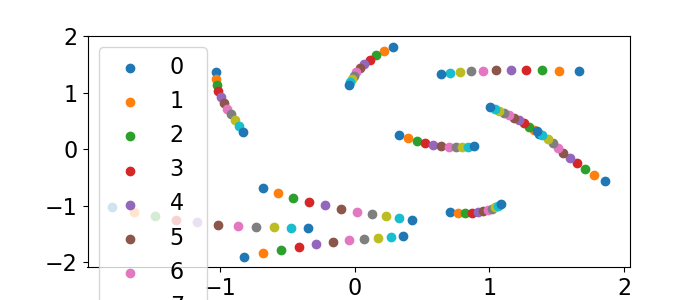

In [15]:
sampled = sample_vf(vf, torch.rand(10, 2) * 4 - 2, 10, t0=0, t1=10)

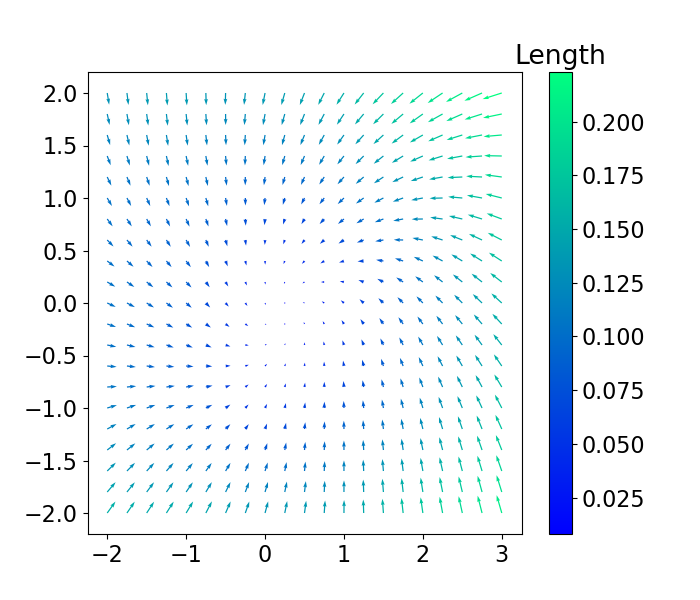

In [195]:
quiver_vf(vf, xs=(-2, 3), ys=(-2, 2))